In [1]:
import os,glob,shutil,pickle,cv2,re
import numpy as np
import scipy as sp
import support_utility_openvino
from sklearn.metrics import pairwise_distances

from itertools import combinations
# from fuzzywuzzy import fuzz

In [5]:
import matplotlib.pyplot as plt
import IPython.display as Disp
import ipywidgets as widgets

class bbox_select():
    %matplotlib notebook 


    def __init__(self,im):
        self.im = im
        self.selected_points = []
        self.fig,ax = plt.subplots()
        self.img = ax.imshow(self.im.copy())
        self.ka = self.fig.canvas.mpl_connect('button_press_event', self.onclick)
        disconnect_button = widgets.Button(description="Disconnect mpl")
        Disp.display(disconnect_button)
        disconnect_button.on_click(self.disconnect_mpl)


        
    def poly_img(self,img,pts):
        pts = np.array(pts, np.int32)
        pts = pts.reshape((-1,1,2))
        cv2.polylines(img,[pts],True,(0,255,255),4)
        return img

    def onclick(self, event):
    #display(str(event))
        self.selected_points.append([event.xdata,event.ydata])
        if len(self.selected_points)>1:
            self.fig
            self.img.set_data(self.poly_img(self.im.copy(),self.selected_points))
    def disconnect_mpl(self,_):
        self.fig.canvas.mpl_disconnect(self.ka)

        
            

In [6]:
def poly_intersection_shapely(pt1,pt2,intersection_threshold=.5):
    """
    bool : return True or False
    """
    p1 = Polygon(pt1)
    p2 = Polygon(pt2)
    intersection_area = p1.intersection(p2).area
    if intersection_area/p2.area>intersection_threshold:
        return True
    return False

<IPython.core.display.Javascript object>


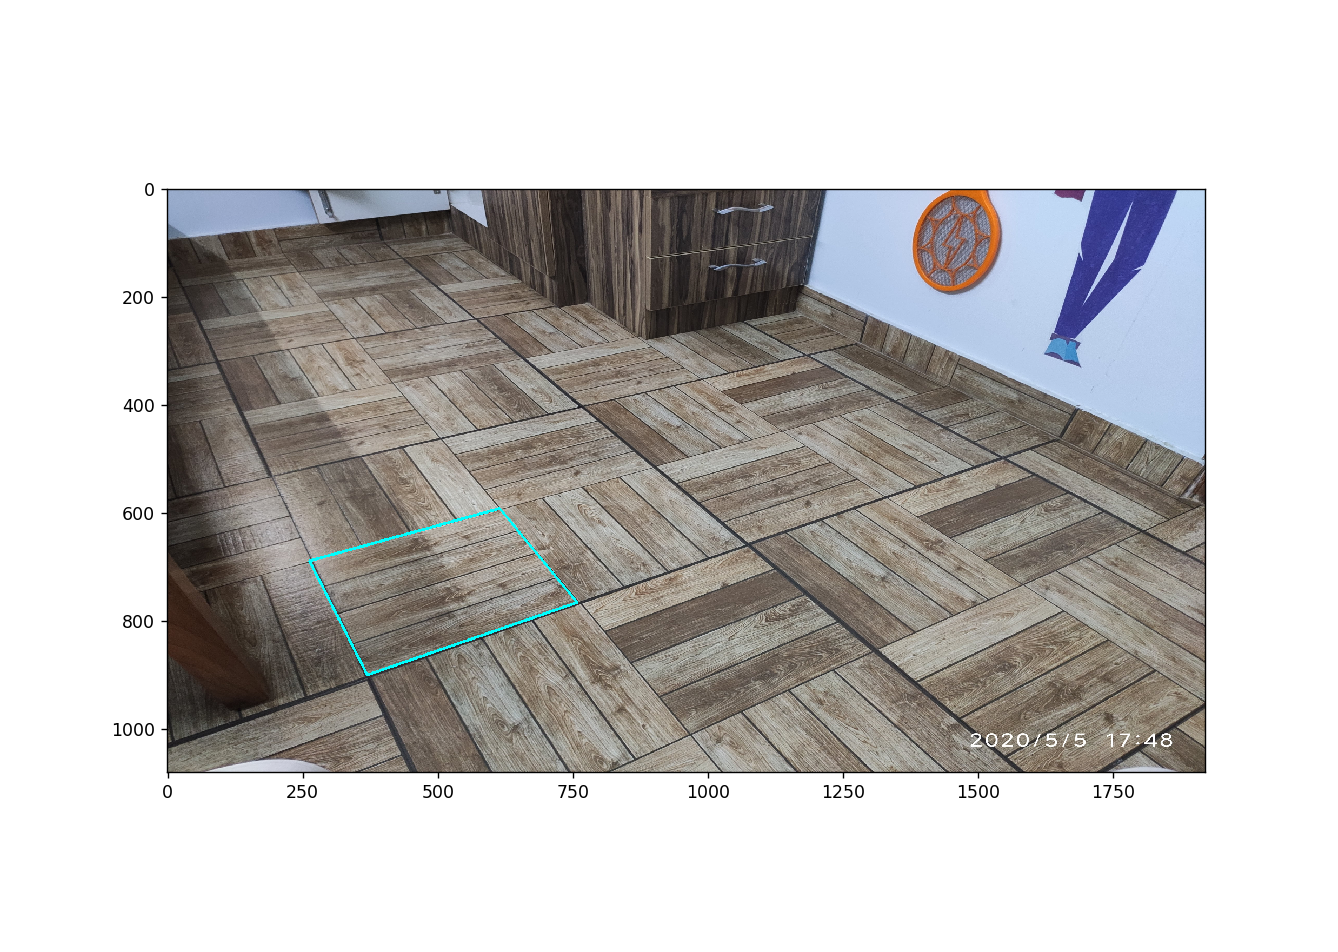

Button(description='Disconnect mpl', style=ButtonStyle())

In [23]:
frame = cv2.imread("output_vids/distance_measurement/sample_image.jpg")
frame = cv2.resize(frame,(1920,1080))
bs = bbox_select(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

In [24]:
width = 30
height = 30

final_points = [[0,0],[width,0],[width,height],[0,height]]


M = cv2.getPerspectiveTransform(np.float32(bs.selected_points),np.float32(final_points))

In [25]:
refpt = []
def click_point(event, x, y,flags, param):
    # grab references to the global variables
    global mouseX, mouseY
    # if the left mouse button was clicked, record the starting
    # (x, y) coordinates and indicate that cropping is being
    # performed
    if event == cv2.EVENT_LBUTTONDOWN:
#         print("left key pressed")
        
        refpt.append([x,y])


In [27]:
cv2.namedWindow("preview",cv2.WINDOW_NORMAL)
cv2.setMouseCallback("preview", click_point)
frame1 = frame.copy()
while True:
    # if the 'r' key is pressed, reset the cropping region

    cv2.imshow("preview",frame1)
    k = cv2.waitKey(1)
    if k==ord('q'):
        break
    if k == ord("r"):
        frame1 = frame.copy()
    if len(refpt) == 2:
        frame1 = cv2.line(frame1,tuple(refpt[0]),tuple(refpt[1]),(0,255,0),2)
        refpt1 = cv2.perspectiveTransform(np.float32([refpt]),M).squeeze()
        dist = sp.spatial.distance.euclidean(refpt1[0],refpt1[1])
        op_frame = cv2.putText(frame1, "dist = %.2f"%dist,(100,100), cv2.FONT_HERSHEY_COMPLEX,  2, (0,0,0), 1, cv2.LINE_AA) 

#         cv2.imshow("preview", frame1)
#         k = cv2.waitKey(0)
        refpt = []


cv2.destroyAllWindows()            